# Setup

In [175]:
#import pdb; pdb.set_trace()

%matplotlib inline  
import pandas as pd
import os
import re
import json

In [176]:
# connection to the database
import os
from sqlalchemy import create_engine

# set username/password here:
db = {'username': os.environ['USERNAME_11323671'],
      'password': os.environ['PASSWORD_11323671'],
      'host': 'quantleap.nl:5432',
      'catalog': 'qir'}

con = 'postgresql://{username}:{password}@{host}/{catalog}'.format(**db)
engine = create_engine(con, echo=True)
print('CONNECTION ESTABLISHED')

CONNECTION ESTABLISHED


# Insolvents

In [177]:
sql = """select count(distinct case_number) 
         from company_insolvents"""

no_insolvents = pd.read_sql(sql, con).iloc[0][0]
print('the total number of insolvents cases in the database is {}'.format(no_insolvents))

the total number of insolvents cases in the database is 49956


In [178]:
sql = """select start_date_insolvency is not null as known, count(*)
         from company_insolvents
         group by start_date_insolvency is not null"""

df_known_start_date = pd.read_sql(sql, con)
print('fraction of known start date')
df_known_start_date

fraction of known start date


,known,count
0,False,3878
1,True,46078


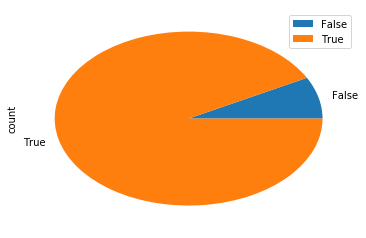

In [179]:
df_known_start_date.plot.pie(y='count', labels=df_known_start_date['known'])

# Judges

In [180]:
sql = """select count(supervisory_judge) as no_cases, supervisory_judge
         from company_insolvents
         group by 2
         order by 1 desc
         limit 10"""

print("top 10 judges by number of cases")
pd.read_sql(sql, con)

top 10 judges by number of cases


,no_cases,supervisory_judge
0,1115,mr. A.E. Zweers
1,1086,mr. C. Schollen-den Besten
2,998,mr. J.S.W. Lucassen
3,912,mr. A.M.P.T. Blokhuis
4,887,mr. P.J. Neijt
5,879,mr. A.E. de Vos
6,803,mr. M Pellikaan
7,768,mr. I.M. Bilderbeek
8,751,mr. S.J.O. de Vries
9,705,mr. M.H.F. van Vugt


## Example of non normalized judge names:

- "mr. W.J.  Geurts - de Veld"
- "mr. W.J. Geurts - de Veld"
- "mr. W.J. Geurts-deVeld"
- "mr. W.J. Geurts-de Veld"
- "mr. W.J.Geurts-de Veld"
- "mr.W.J. Geurts-de Veld"
- "mr. W.J. Geurts-de Veld (Rotterdam)"
- "mr W.J.Geurts-de Veld"
- "W.J.Geurts-de Veld"

correct: "mr. W.J. Geurts-de Veld"
normalized: "wj geurts-de veld"

normalization steps:
1. make lowercase
2. remove leading mr[.]
3. remove spaces around dash
4. remove dots
5. replace double spaces by single space
6. remove parentheses and text within
7. strip leading and trailing spaces


In [181]:
sql = """select distinct supervisory_judge
         from company_insolvents
         where supervisory_judge notnull
         order by 1"""

non_normalized_name = pd.read_sql(sql, con)

def normalize_judge_name(name):
    return name.replace(r"\(.*\)","")
    

non_normalized_name['supervisory_judge'].apply(normalize_judge_name)[0:10]


0                         A.E. Vos
1                    A.K. Korteweg
2    A.M.P.T. Blokhuis (RB Arnhem)
3               A.M. van Kalmthout
4          B.J.G.M. Ides - Peeters
5                     C.P. Bleeker
6                      C.P. Lunter
7           C. Schollen-den Besten
8                     C.T.M. Luyks
9       dhr. mr. A.C.A. Wildenburg
Name: supervisory_judge, dtype: object

In [182]:
# rechters_df = pd.read_html('http://ors.openstate.eu/relations')[0]
rechters_df = pd.read_json('http://ors.openstate.eu/relations/json')

In [183]:
rechters_df

,name,set,uri
0,mw. mr. J.F. Aalders,Rechtbank Amsterdam,http://ors.openstate.eu/relations/instantie/Re...
1,mw. mr. L.Z. Achouak El Idrissi,Rechtbank Amsterdam,http://ors.openstate.eu/relations/instantie/Re...
2,dhr. mr. M.J. Alink,Rechtbank Amsterdam,http://ors.openstate.eu/relations/instantie/Re...
3,mw. mr. L.C. Bachrach,Rechtbank Amsterdam,http://ors.openstate.eu/relations/instantie/Re...
4,dhr. mr. J.J. Bade,Rechtbank Amsterdam,http://ors.openstate.eu/relations/instantie/Re...
5,mw. mr. L. Baggerman,Rechtbank Amsterdam,http://ors.openstate.eu/relations/instantie/Re...
6,dhr. mr. M. Bakhuis,Rechtbank Amsterdam,http://ors.openstate.eu/relations/instantie/Re...
7,mw. mr. K. Oldekamp-Bakker,Rechtbank Amsterdam,http://ors.openstate.eu/relations/instantie/Re...
8,mw. mr. C. Bakker,Rechtbank Amsterdam,http://ors.openstate.eu/relations/instantie/Re...
9,mw. mr.dr. H.J.M. Baldinger,Rechtbank Amsterdam,http://ors.openstate.eu/relations/instantie/Re...


In [184]:
rechters_df[rechters_df['set'] == 'Rechtbank Amsterdam']

,name,set,uri
0,mw. mr. J.F. Aalders,Rechtbank Amsterdam,http://ors.openstate.eu/relations/instantie/Re...
1,mw. mr. L.Z. Achouak El Idrissi,Rechtbank Amsterdam,http://ors.openstate.eu/relations/instantie/Re...
2,dhr. mr. M.J. Alink,Rechtbank Amsterdam,http://ors.openstate.eu/relations/instantie/Re...
3,mw. mr. L.C. Bachrach,Rechtbank Amsterdam,http://ors.openstate.eu/relations/instantie/Re...
4,dhr. mr. J.J. Bade,Rechtbank Amsterdam,http://ors.openstate.eu/relations/instantie/Re...
5,mw. mr. L. Baggerman,Rechtbank Amsterdam,http://ors.openstate.eu/relations/instantie/Re...
6,dhr. mr. M. Bakhuis,Rechtbank Amsterdam,http://ors.openstate.eu/relations/instantie/Re...
7,mw. mr. K. Oldekamp-Bakker,Rechtbank Amsterdam,http://ors.openstate.eu/relations/instantie/Re...
8,mw. mr. C. Bakker,Rechtbank Amsterdam,http://ors.openstate.eu/relations/instantie/Re...
9,mw. mr.dr. H.J.M. Baldinger,Rechtbank Amsterdam,http://ors.openstate.eu/relations/instantie/Re...


# Verslagen

## Split voortgangs vs financiele rapportages

In [185]:
sql = """select 
           count(*), 
           count(*)::decimal/(select count(*) from reports)*100 as pct, 
           right(identification, 1) = 'B' as is_financial_report
         from reports
         group by 3;"""
pd.read_sql(sql, con)

,count,pct,is_financial_report
0,201795,64.034868,False
1,113338,35.965132,True


## Split PDF was scanned vs converted

In [186]:
sql = """select 
           count(*), 
           count(*)::decimal/(select count(*) from reports)*100 as pct, 
           is_ocr as was_scanned
         from reports
         group by 3;"""
pd.read_sql(sql, con)

,count,pct,was_scanned
0,130253,41.332707,None
1,82627,26.219723,True
2,102253,32.447570,False


todo: run new classifier over all pdfs on S3 for unknowns

## praktijk van het rapporteren voortgangsverslagen met/zonder financiele bijlage

In [187]:
sql = """select * from progess_financial_report_cooccurence;"""
df = pd.read_sql(sql, con)
df = df.transpose()
df.columns = ['count']
df['pct'] = df['count']/df['count'].sum()*100
df

,count,pct
zero_financial_reports,12850,33.940835
zero_progress_reports,36,0.095087
more_progress_reports,12885,34.033281
more_financial_report,790,2.086635
equal_no_of_reports,11299,29.844163


## rapportages over tijd

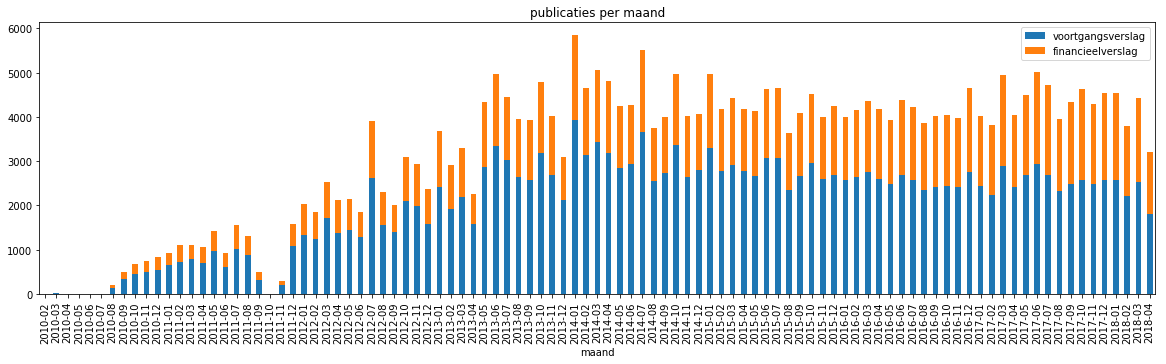

In [188]:
sql = """
with
financial as (
      select to_char(publication_date, 'YYYY-MM') as month,
             count(*) as financial_count
      from reports
      where right(identification, 1) = 'B'
      group by 1),
progress as (
      select to_char(publication_date, 'YYYY-MM') as month,
             count(*) as progres_count
      from reports
      where right(identification, 1) != 'B'
      group by 1)
select prog.month as maand, progres_count as voortgangsverslag, coalesce(financial_count, 0) as financieelverslag
  from financial fin
    full outer join progress prog on fin.month = prog.month
  order by prog.month;
"""
df = pd.read_sql(sql, con, index_col="maand")
df.plot.bar(stacked=True, figsize=(20, 5), title='publicaties per maand')

## steekproef van niet OCR eindverslagen

In [189]:
sql = '''SELECT identification, publication_date, is_end_report, content, start_date_insolvency
         FROM reports rep
             JOIN company_insolvents ins ON rep.insolvent_id = ins.id
         WHERE rep.is_end_report = TRUE
             AND is_ocr is FALSE
         ORDER BY publication_date DESC
         LIMIT 1000;'''

df_reports = pd.read_sql(sql, con, index_col='identification')
df_reports.head()

,publication_date,is_end_report,content,start_date_insolvency
identification,,,,
01_obr_13_608_F_V_11,2018-04-17 12:10:08,True,VANIERSEL\nLUCHTMAN\nCAT E N\n\nOPENBAAR FAIL...,2013-06-18
01_obr_13_400_F_V_11,2018-04-17 12:08:10,True,VANIERSEL\nLUCHTMAN\nADVOCATEN\n\nOPEN BAAR FA...,2013-04-23
01_obr_13_399_F_V_10,2018-04-17 12:06:21,True,VANIERSEL\nLUCHTMAN\nADVOCATEN\n\nOPE N BAAR ...,2013-04-23
01_obr_15_133_F_V_07,2018-04-17 12:01:37,True,VANIERSEL\nLUCHTMAN\nADVOCATEN\n\nOpenbaar fa...,2015-02-24
01_obr_14_973_F_V_08,2018-04-17 12:00:46,True,VANIERSEL\nLUCHTMAN\nADVOCATEN\n\nOpenbaar fa...,2014-12-16


## Data field wish list from the PDF report

### Wenselijke datavelden in het voortgangsverslag
Het voortgangsverslag hoort gestructureerd te zijn volgens de RECOFA richtlijnenm zie **model-verslag-faillissement-rechtspersoon.pdf**. In eerste instantie zijn we geinteresseerd in de data uit de **eindverslagen**.

Algemeen
- Personeel gemiddeld aantal: aantal
- Bestede uren totaal: aantal
- Saldo boedelrekening: bedrag


4 Debiteuren

4.2 Opbrengst: bedrag


7 Rechtmatigheid

7.2 Depot jaarrekeningen: wel/niet 

7.5 Onbehoorlijk bestuur: wel/niet


8 Crediteuren

8.1 Boedelvorderingen: bedrag (salaris curator / UWV / ..)

8.2 Preferente vorderingen van de fiscus: bedrag

8.3 Preferente vorderingen van het UWV: bedrag

8.4 Andere preferente vorderingen: bedrag

8.5 Aantal concurrente crediteuren: bedrag

8.6 Bedrag concurrente crediteuren: bedrag



### Bevindingen / Issues
- Bij insolventen van verslagen 13_ams_15_478_F_V_06 en 10_rot_12_90_F_V_16 zijn geen enkele financiele verslagen ook curator salaris wordt niet genoemd. Vraag: wie levert geen financieel verslag en waarom?
- Bij eindverslag 10_rot_14_1054_F_V_10 staat curator salaris alleen in de financiele bijlage. Er lijkt ook sprake van een schikking - regeling bestuurder: 22.000 - wegens rechtmatigheidsissue. 
- bij 11_rot_12_41_F_V_15 staan bedragen doorgestreept, textconversie pakt dat niet
- De eindverslagen zijn niet echt eindverslagen: 'Naar verwachting zal het faillissement in de komende
verslagperiode eindigen.' (11_rot_12_41_F_V_15)
- uurtarief bij 11_rot_12_41_F_V_15 komt op 280,-
- 10_rot_14_1054_F_V_10, 01_obr_13_293_F_V_09 omzetting pdf>txt verliest letters/gegevens/structuur met PDFMiner. Welke converter pakt dit goed aan ?
- strikethrough in PDF komt niet terug in de tekstconversie

## Extracting structured text from PDF reports

### Kandidaat sectie headers

In [190]:
# Step 1: extract sections from progress reports
# Sub step: extract candidate sections from model report
model_content = open('model-verslag-faillissement-rechtspersoon.txt', 'r').read()

def match_headings(content, level=2):
    """ returns level 2 (e.g. 1.1) heading matches as tuple (heading number, heading title)"""
    flags = re.MULTILINE
    if level == 2:
        pattern = r"^\s*(\d{1,2}\.\d{1,2})\s*(.*)$"
    elif level == 1:
        pattern = r"^\s*(\d{1,2}\.\d{0,2})\s*(.*)$"
    else:
        raise NotImplementedError
    match = re.findall(pattern, content, flags)
    return match

model_headings = match_headings(model_content, level=1)
model_heading_numbers = list(zip(*model_headings))[0]
model_headings

[('1.', 'Inventarisatie'),
 ('1.1', 'Directie en organisatie'),
 ('1.2', 'Winst en verlies'),
 ('1.3', 'Balanstotaal'),
 ('1.4', 'Lopende procedures'),
 ('1.5', 'Verzekeringen'),
 ('1.6', 'Huur'),
 ('1.7', 'Oorzaak faillissement'),
 ('2.', 'Personeel'),
 ('2.1', 'Aantal ten tijde van faillissement'),
 ('2.2', 'Aantal in jaar voor faillissement'),
 ('2.3', 'Datum ontslagaanzegging'),
 ('2.4', 'Werkzaamheden'),
 ('3.', 'Activa'),
 ('3.1', 'Beschrijving'),
 ('3.2', 'Verkoopopbrengst'),
 ('3.3', 'Hoogte hypotheek'),
 ('3.4', 'Boedelbijdrage'),
 ('3.5', 'Werkzaamheden'),
 ('3.6', 'Beschrijving'),
 ('3.7', 'Verkoopopbrengst'),
 ('3.8', 'Boedelbijdrage'),
 ('3.9', 'Bodemvoorrecht fiscus'),
 ('3.10', 'Werkzaamheden'),
 ('3.11', 'Beschrijving'),
 ('3.12', 'Verkoopopbrengst'),
 ('3.13', 'Boedelbijdrage'),
 ('3.14', 'Werkzaamheden'),
 ('3.15', 'Beschrijving'),
 ('3.16', 'Verkoopopbrengst'),
 ('3.17', 'Werkzaamheden'),
 ('4.', 'Debiteuren'),
 ('4.1', 'Omvang debiteuren'),
 ('4.2', 'Opbrengst'),
 (

In [191]:
report_content = df_reports['content']['01_obr_13_1204_F_V_04']
print(report_content)

VANIERSEL
LUCHTMAN
ADVOCATEN

Openbaar  faillissementsverslag rechtspersoon  ex art. 73a  Fw.

(digitale  en papieren versie zijn identiek)

Datum: 27 maarl2018

EINDVERSLAG

Nummer:3

Gegevens  onderneming

de naamloze vennootschap  naar het recht van Curaçao
INTERACTIVE  DESIGN  CHRYSTAL N.V., hierna te noemen:  "de
vennootschap", gevestigd en kantoorhoudende aan De Run 2180 te
(5503 LE) Veldhoven, ingeschreven bij de Kamer  van Koophandel  te
Brabant  onder nummer 17111379.

Faillissementsnummer

F.01.1311204

Datum uitspraak
Curator
Rechter-commissaris

24 december 2013
mr. R.G.  Roeffen
mr. C. Schollen-den Besten

Activiteiten ondernem  ing

De vennootschap hield zich volgens  het uittreksel  uit het
handelsregister  van de Kamer  van Koophandel  onder meer bezig
met het verlenen van diensten op het gebied van informatie-  en
communicatietechnologie  alsmede met het ondersteunen  van
activiteiten  ten behoeve  van de ontwikkeling  van SD technologie.

Omzetgegevens

2013:  €  41 .

In [192]:
report_headings = match_headings(report_content, level=1)
report_heading_numbers = list(zip(*report_headings))[0]



In [193]:
# BREADTH FIRST SEARCH: eerst van zoveel mogelijk rapporten een zo weid mogelijk net uitgooien, dan inzoomen
# 0. eigenlijk eerst full text search op gehele content
# 1. search op sections
# 2. search op parameter values

# SECTIONS
# check hoeveel er exact matchen(ignore case)
# check hoeveel er op heading nummers matchen
# for stop anchor point we need to level 1 headings too

# ZOU MATCH OP HEADING NUMMER AL GENOEG KUNNEN ZIJN ? :
# check of heading nummers oplopen
# check of heading nummers in kandidatenlijst voorkomen

# level 1 pattern with .? yields many false positives (in first examined case)

def is_strictly_increasing_heading_numbers(heading_numbers):
    """ checks if all level 2 headings 1.1, 1.2, 3.1 etc in list are strictly increasing. """
    if heading_numbers is not None:
        return all([float(a) < float(b) for (a, b) in zip(heading_numbers, heading_numbers[1:])])
    else:
        return False
    
def only_model_headings(report_heading_numbers):
    if report_heading_numbers is not None:
        report_headings_not_in_model = set(report_heading_numbers).difference(set(model_heading_numbers))
        return len(report_headings_not_in_model) == 0
    else:
        return False


def get_heading_numbers(content):
    headings = match_headings(content)
    if headings:
        heading_numbers, _ = list(zip(*headings))
        return heading_numbers
    else:
        return None
  


print('is strictly increasing: {}'.format(is_strictly_increasing_heading_numbers(report_heading_numbers)))
print('all headings report in model: {}'.format(all_report_headings_in_model(report_heading_numbers, model_heading_numbers)))

is strictly increasing: True
all headings report in model: True


In [194]:
# store matched headers as json strings
df_reports['headings'] = df_reports['content'].apply(lambda x: json.dumps(match_headings(x)))
df_reports['headings']

identification
01_obr_13_608_F_V_11     [["1.1", "Directie  en organisatie"], ["1.2", ...
01_obr_13_400_F_V_11     [["1.1", "Directie  en organisatie"], ["1.2", ...
01_obr_13_399_F_V_10     [["1.07", "2.175,-"], ["1.1", "Directie  en or...
01_obr_15_133_F_V_07     [["1.1", "Directie  en organisatie"], ["1.13",...
01_obr_14_973_F_V_08     [["1.1", "Directie  en organisatie"], ["76.95"...
10_rot_14_1054_F_V_10    [["1.1", "Directie en organisatie "], ["1.2", ...
10_rot_14_1055_F_V_10    [["1.1", "Directie en organisatie "], ["1.2", ...
10_rot_12_90_F_V_16      [["1.1", "Directie en Organisatie"], ["1.2", "...
11_rot_12_41_F_V_15      [["1.1", "Inventarisatie "], ["1.2", "Winst en...
13_ams_15_478_F_V_06     [["1.1", ".  Directie en organisatie "], ["1.2...
05_gel_16_674_F_V_05     [["1.1", "Directie en organisatie"], ["1.2", "...
05_gel_16_666_F_V_05     [["1.1", "Directie en organisatie"], ["1.2", "...
16_mne_16_568_F_V_01     [["1.1", "Directie en organisatie"], ["1.2", "...
05_gel_16_

In [195]:
df_reports['heading_numbers'] = df_reports['content'].apply(lambda x: json.dumps(get_heading_numbers(x)))
df_reports['heading_numbers']

identification
01_obr_13_608_F_V_11     ["1.1", "1.2", "1.3", "1.4", "20.84", "46.29",...
01_obr_13_400_F_V_11     ["1.1", "1.2", "1.3", "1.4", "1.5", "1.6", "2....
01_obr_13_399_F_V_10     ["1.07", "1.1", "1.2", "1.3", "1.4", "1.5", "1...
01_obr_15_133_F_V_07     ["1.1", "1.13", "56.10", "1.2", "1.3", "1.4", ...
01_obr_14_973_F_V_08     ["1.1", "76.95", "68.09", "3.42", "1.2", "1.3"...
10_rot_14_1054_F_V_10    ["1.1", "1.2", "1.3", "1.4", "1.5", "1.6", "1....
10_rot_14_1055_F_V_10    ["1.1", "1.2", "1.3", "1.4", "1.5", "1.6", "1....
10_rot_12_90_F_V_16      ["1.1", "1.2", "1.4", "1.6", "2.1", "2.3", "3....
11_rot_12_41_F_V_15      ["1.1", "1.2", "1.3", "1.4", "1.5", "1.6", "1....
13_ams_15_478_F_V_06     ["1.1", "1.2", "1.3", "1.4", "1.5", "1.6", "1....
05_gel_16_674_F_V_05     ["1.1", "1.2", "1.3", "1.4", "1.5", "1.6", "1....
05_gel_16_666_F_V_05     ["1.1", "1.2", "1.3", "1.4", "1.5", "1.6", "1....
16_mne_16_568_F_V_01     ["1.1", "1.2", "1.3", "1.4", "1.5", "1.6", "1....
05_gel_16_

In [196]:
df_reports['strictly_increasing'] = df_reports['heading_numbers'].apply(
    lambda x: is_strictly_increasing_heading_numbers(json.loads(x)))
df_reports['strictly_increasing']

identification
01_obr_13_608_F_V_11     False
01_obr_13_400_F_V_11     False
01_obr_13_399_F_V_10     False
01_obr_15_133_F_V_07     False
01_obr_14_973_F_V_08     False
10_rot_14_1054_F_V_10    False
10_rot_14_1055_F_V_10    False
10_rot_12_90_F_V_16      False
11_rot_12_41_F_V_15      False
13_ams_15_478_F_V_06     False
05_gel_16_674_F_V_05     False
05_gel_16_666_F_V_05     False
16_mne_16_568_F_V_01     False
05_gel_16_660_F_V_05     False
01_obr_13_1204_F_V_04     True
01_obr_13_293_F_V_09     False
01_obr_15_189_F_V_07     False
01_obr_15_188_F_V_08     False
13_ams_14_651_F_V_06      True
13_ams_14_497_F_V_07      True
01_obr_13_1107_F_V_08    False
10_rot_11_359_F_V_15     False
18_nne_15_225_F_V_11     False
10_rot_14_725_F_V_11     False
10_rot_14_693_F_V_08     False
13_ams_15_42_F_V_06       True
13_ams_13_6_F_V_14       False
13_ams_15_15_F_V_09      False
13_ams_09_386_F_V_18     False
10_rot_12_592_F_V_12     False
                         ...  
01_obr_15_30_F_V_03     

In [197]:
# report percentage strictly increasing
df_reports['strictly_increasing'][df_reports['strictly_increasing'] == True].count() / df_reports['strictly_increasing'].count() * 100

22.400000000000002

In [198]:
df_reports['only_model_headings'] = df_reports['heading_numbers'].apply(
    lambda x: is_strictly_increasing_heading_numbers(json.loads(x)))
df_reports['strictly_increasing']

identification
01_obr_13_608_F_V_11     False
01_obr_13_400_F_V_11     False
01_obr_13_399_F_V_10     False
01_obr_15_133_F_V_07     False
01_obr_14_973_F_V_08     False
10_rot_14_1054_F_V_10    False
10_rot_14_1055_F_V_10    False
10_rot_12_90_F_V_16      False
11_rot_12_41_F_V_15      False
13_ams_15_478_F_V_06     False
05_gel_16_674_F_V_05     False
05_gel_16_666_F_V_05     False
16_mne_16_568_F_V_01     False
05_gel_16_660_F_V_05     False
01_obr_13_1204_F_V_04     True
01_obr_13_293_F_V_09     False
01_obr_15_189_F_V_07     False
01_obr_15_188_F_V_08     False
13_ams_14_651_F_V_06      True
13_ams_14_497_F_V_07      True
01_obr_13_1107_F_V_08    False
10_rot_11_359_F_V_15     False
18_nne_15_225_F_V_11     False
10_rot_14_725_F_V_11     False
10_rot_14_693_F_V_08     False
13_ams_15_42_F_V_06       True
13_ams_13_6_F_V_14       False
13_ams_15_15_F_V_09      False
13_ams_09_386_F_V_18     False
10_rot_12_592_F_V_12     False
                         ...  
01_obr_15_30_F_V_03     

In [199]:
df_reports['only_model_headings'] = df_reports['heading_numbers'].apply(
    lambda x: only_model_headings(json.loads(x)))
df_reports['only_model_headings']

identification
01_obr_13_608_F_V_11     False
01_obr_13_400_F_V_11     False
01_obr_13_399_F_V_10     False
01_obr_15_133_F_V_07     False
01_obr_14_973_F_V_08     False
10_rot_14_1054_F_V_10     True
10_rot_14_1055_F_V_10     True
10_rot_12_90_F_V_16      False
11_rot_12_41_F_V_15      False
13_ams_15_478_F_V_06     False
05_gel_16_674_F_V_05      True
05_gel_16_666_F_V_05      True
16_mne_16_568_F_V_01      True
05_gel_16_660_F_V_05      True
01_obr_13_1204_F_V_04     True
01_obr_13_293_F_V_09      True
01_obr_15_189_F_V_07     False
01_obr_15_188_F_V_08     False
13_ams_14_651_F_V_06     False
13_ams_14_497_F_V_07     False
01_obr_13_1107_F_V_08     True
10_rot_11_359_F_V_15     False
18_nne_15_225_F_V_11      True
10_rot_14_725_F_V_11     False
10_rot_14_693_F_V_08      True
13_ams_15_42_F_V_06       True
13_ams_13_6_F_V_14       False
13_ams_15_15_F_V_09       True
13_ams_09_386_F_V_18     False
10_rot_12_592_F_V_12     False
                         ...  
01_obr_15_30_F_V_03     

In [200]:
# report percentage only model headings
df_reports['only_model_headings'][df_reports['only_model_headings'] == True].count() / df_reports['only_model_headings'].count() * 100

50.700000000000003

In [201]:
# inspect not strictly increasing
df_not_increasing = df_reports[df_reports.only_model_headings & (~df_reports.strictly_increasing)]
index = 20
print(df_not_increasing.index[index])
heading_numbers = list(zip(*json.loads(df_not_increasing.headings[index])))[0]
is_strictly_increasing_heading_numbers(heading_numbers)
for a, b in zip(heading_numbers, heading_numbers[1:]):
    print(float(a), float(b), float(a)<float(b))
    
# finding: in many reports 3.10 became 3.1 even though the PDF shows 3.10, PDFMiner issue ?


10_rot_14_762_F_V_09
1.1 1.2 True
1.2 1.3 True
1.3 1.5 True
1.5 1.7 True
1.7 2.1 True
2.1 2.3 True
2.3 5.1 True
5.1 5.2 True
5.2 5.4 True
5.4 5.6 True
5.6 5.8 True
5.8 7.1 True
7.1 7.2 True
7.2 7.4 True
7.4 8.1 True
8.1 8.3 True
8.3 8.5 True
8.5 7.6 False
7.6 10.1 True
10.1 10.3 True
